In [219]:
import pandas as pd
import os
import collections
import csv
import logging
import numpy as np
import datetime as datetime
import types
import pickle

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from top2vec import Top2Vec

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
!which jupyter

/home/ubuntu/thesis_env2/bin/jupyter


In [3]:
df = pd.read_pickle('./data/df_processed_bigrams.pickle')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365200 entries, 0 to 369046
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   author             181507 non-null  object        
 1   date               365200 non-null  datetime64[ns]
 2   domain             365200 non-null  object        
 3   title              365115 non-null  object        
 4   url                365200 non-null  object        
 5   content            365200 non-null  object        
 6   topic_area         365200 non-null  object        
 7   content_processed  365200 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 25.1+ MB


In [5]:
df.head(1).append(df.tail(1))

,author,date,domain,title,url,content,topic_area,content_processed
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...


In [6]:
# Note to do - need to add time element

def log_newline(self, how_many_lines=1):
    file_handler = None
    if self.handlers:
        file_handler = self.handlers[0]

    # Switch formatter, output a blank line
    file_handler.setFormatter(self.blank_formatter)
    for i in range(how_many_lines):
        self.info('')

    # Switch back
    file_handler.setFormatter(self.default_formatter)

def logger_w2v():
    
    log_file = os.path.join('./data', 'word2vec.log')
    print('log file location: ', log_file)
    
    log_format= '%(asctime)s - %(levelname)s - [%(module)s]\t%(message)s'
    formatter = logging.Formatter(fmt=(log_format))
    
    fhandler = logging.FileHandler(log_file)
    fhandler.setFormatter(formatter)
    
    logger = logging.getLogger('word2vec')
    logger.setLevel(logging.DEBUG)
    logger.addHandler(fhandler)
    logger.default_formatter = formatter
    logger.blank_formatter = logging.Formatter(fmt="")
    logger.newline = types.MethodType(log_newline, logger)
    
    return logger
    

In [7]:
def tokenise_dataset(df):

    tokens = df['content_processed'].str.split(" ")

    return tokens

# Top2Vec

In [8]:
find_topics = False
min_count = 1000 # ignore words with total frequency less than this
speed = 'deep-learn' # can try 'deep-learn' for possible better embeddings but will take longer
# started deep-lear at 8pm, still going at 2pm the next day

if find_topics:
    # import lemmatised data
    with open('data/data_lemmatized.pickle', 'rb') as f:
        data_lemmatized = pickle.load(f)
    
    data_lemmatized_str = [' '.join(article) for article in data_lemmatized]
    print(len(data_lemmatized))
    print(len(data_lemmatized_str))
    
    # Find topics
    # ~ 12.5 hours to run on lemmatised data
    #documents = df['content_processed'][:50000].values
    documents = data_lemmatized_str
    model = Top2Vec(documents, workers=4, min_count=min_count, speed=speed)
    model.save('top2vec_vocab_limit_deep.model')
else:
    #model = Top2Vec.load('top2vec.model')
    model = Top2Vec.load('top2vec_vocab_limit.model')
    #model = Top2Vec.load('top2vec_vocab_limit_deep.model')

print(len(model.topic_words))
print(model._get_word_vectors().shape)

1773
(9453, 300)


In [9]:
print(model.topic_words[0], '\n')
#print(model.topic_words[1], '\n')
#print(model.topic_words[2], '\n')

['barrels_day' 'bpd' 'crude' 'opec' 'glut' 'oil' 'barrel' 'refiner'
 'brent_crude' 'wti' 'eia' 'brent' 'crude_future' 'gasoline' 'shale'
 'crude_oil' 'refinery' 'output' 'libya' 'exxon' 'aramco' 'refining'
 'permian' 'producer' 'chevron' 'petroleum' 'saudi' 'reuters_poll'
 'importer' 'oil_ga' 'upstream' 'rig' 'hydrocarbon' 'rout' 'taper'
 'natural_ga' 'gulf' 'petrochemical' 'oilfield' 'refine' 'oil_gas'
 'curtailment' 'iraq' 'royal_dutch' 'diesel' 'chesapeake' 'lowest_level'
 'gallon' 'gregorio' 'slash'] 



### Get topic sizes

Number of documents most similar to each topic. Topics are in decreasing order of size.  
topic_sizes: The number of documents most similar to each topic.  
topic_nums: The unique index of every topic will be returned.  

In [10]:
topic_sizes, topic_ids = model.get_topic_sizes()
df_topic_sizes = pd.DataFrame(data=zip(topic_ids, topic_sizes), columns=['topic_id', 'num_docs'])

In [11]:
print(df_topic_sizes['num_docs'].sum())
df_topic_sizes

365200


,topic_id,num_docs
0,0,3882
1,1,2972
2,2,2739
3,3,2512
4,4,2155
...,...,...
1768,1768,19
1769,1769,19
1770,1770,18
1771,1771,18


<AxesSubplot:>

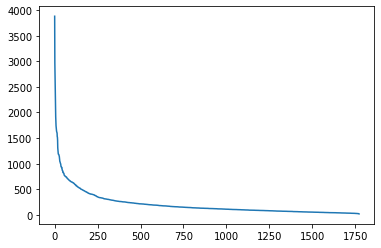

In [12]:
df_topic_sizes['num_docs'].plot()

### Get Topics
topic_words: For each topic the top 50 words are returned, in order of semantic similarity to topic.  
word_scores: For each topic the cosine similarity scores of the top 50 words to the topic are returned.  
topic_nums: The unique index of every topic will be returned.  

In [13]:
topic_words, word_scores, topic_ids = model.get_topics(model.get_num_topics())
topic_sizes, topic_ids = model.get_topic_sizes()
df_topics = pd.DataFrame(data=zip(topic_ids, topic_sizes, topic_words, word_scores), columns=['topic_id', 'topic_sizes', 'topic_words', 'word_scores'])

# add doc id's
df_topics['doc_ids'] = ''
for topic_idx, topic_size in enumerate(df_topics['topic_sizes']):
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_idx, num_docs=topic_size)
    df_idx = df.iloc[document_ids].index.values
    df_topics['doc_ids'].at[topic_idx] = df_idx
print(df_topics['topic_sizes'].sum())

#df_topics.to_pickle("df_topics_top2vec_vocab_limit.pickle")

365200


In [14]:
df_topics

,topic_id,topic_sizes,topic_words,word_scores,doc_ids
0,0,3882,"[barrels_day, bpd, crude, opec, glut, oil, bar...","[0.7554733, 0.7397255, 0.7277012, 0.7076352, 0...","[48334, 48284, 294425, 159978, 20322, 292171, ..."
1,1,2972,"[touching_face, hands_clean, sick, rate_dippe,...","[0.31247112, 0.20629022, 0.20435627, 0.2030590...","[676, 30063, 20903, 18668, 21959, 21573, 3624,..."
2,2,2739,"[nongaap, gaap, ebitdare, divestiture, teekay,...","[0.26054233, 0.23778984, 0.22579505, 0.1927944...","[334982, 239075, 91056, 85241, 100487, 8321, 1..."
3,3,2512,"[vaccine, pfizer_biontech, pfizerbiontech, pfi...","[0.80440575, 0.7686322, 0.7623384, 0.7583906, ...","[236636, 225984, 225378, 225321, 347974, 22533..."
4,4,2155,"[hedge_fund, insider_monkey, hedgie, similarly...","[0.7718193, 0.57161814, 0.5356776, 0.51193756,...","[133035, 171698, 133512, 169086, 133335, 17170..."
...,...,...,...,...,...
1768,1768,19,"[safehaven, crude_future, greenback, japanese_...","[0.55273753, 0.49876994, 0.49868113, 0.4946041...","[183052, 183053, 182081, 181526, 181789, 18255..."
1769,1769,19,"[strategist, choppy, treasury_yield, selloff, ...","[0.44933143, 0.42233846, 0.41821185, 0.3859547...","[250960, 250028, 252600, 250770, 253406, 24993..."
1770,1770,18,"[gift, card, debit, wallet, credit_card, press...","[0.5080503, 0.49814865, 0.40992847, 0.384071, ...","[314138, 313298, 314772, 313117, 314512, 31364..."
1771,1771,18,"[dare, commercialize, nda, bioscience, investi...","[0.50853056, 0.4186489, 0.3713347, 0.3697553, ...","[158636, 159688, 154610, 155910, 316975, 31669..."


### Search for topics than contain keywords
topic_words: For each topic the top 50 words are returned, in order of semantic similarity to topic.  
word_scores: For each topic the cosine similarity scores of the top 50 words to the topic are returned.  
topic_scores: For each topic the cosine similarity to the search keywords will be returned.  
topic_nums: The unique index of every topic will be returned.  

In [15]:
keywords = ["supply_chain"]
#keywords = ["digital_transformation"]
topic_words, word_scores, topic_scores, topic_ids = model.search_topics(keywords=keywords, num_topics=5)
df_topic_kw = pd.DataFrame(data=zip(topic_ids, topic_words, word_scores, topic_scores), columns=['topic_id', 'topic_words', 'word_scores', 'topic_scores'])

In [16]:
df_topic_kw

,topic_id,topic_words,word_scores,topic_scores
0,859,"[generic, pharmaceutical, drug, novartis, phar...","[0.5529777, 0.41644132, 0.4071582, 0.37119797,...",0.332119
1,914,"[garment, bangladesh, boohoo, clothing, clothe...","[0.7322744, 0.50282276, 0.46981946, 0.46685526...",0.287537
2,93,"[tools_checklist, reinvent, transformation, ag...","[0.5508231, 0.49446157, 0.48091435, 0.477627, ...",0.252878
3,825,"[wto, multilateral, directorgeneral, bilateral...","[0.78679776, 0.5122057, 0.4868957, 0.46711993,...",0.246379
4,1132,"[respirator, fema, surgical_mask, protective_g...","[0.5727843, 0.45496583, 0.4493539, 0.43521297,...",0.242761


In [17]:
df_topic_kw['topic_words'][4]

array(['respirator', 'fema', 'surgical_mask', 'protective_gear',
       'general_motor', 'gown', 'invoke', 'face_shield', 'ventilator',
       'ppe', 'navarro', 'hhs', 'ford_motor', 'gm', 'goggle', 'azar',
       'lifesaving', 'procure', 'pentagon', 'shortage', 'reuse',
       'honeywell', 'fiat_chrysler', 'defense', 'manufacturer',
       'facemask', 'ford', 'automaker', 'esper', 'compel', 'supply_chain',
       'mask', 'supplier', 'task_force', 'cotton', 'stockpile', 'kushner',
       'scarce', 'lifesave', 'test_kit', 'supplychain', 'masks_glove',
       'redfield', 'prototype', 'operation_warp', 'covering', 'replenish',
       'administration', 'procurement', 'cloth'], dtype='<U15')

In [18]:
df_topic_kw['topic_words'][1]

array(['garment', 'bangladesh', 'boohoo', 'clothing', 'clothe', 'apparel',
       'textile', 'fashion', 'factory', 'cambodia', 'migrant_worker',
       'cotton', 'myanmar', 'bof', 'footwear', 'adida', 'designer',
       'gucci', 'levi', 'leather', 'burberry', 'exporter', 'supply_chain',
       'nepal', 'shoe', 'tshirt', 'retailer', 'minimum_wage', 'malaysian',
       'malaysia', 'gown', 'ngo', 'nike', 'exploitation', 'jc_penney',
       'casual', 'wage', 'jacket', 'vietnam', 'dress', 'fabric',
       'store_closure', 'informal', 'ethiopia', 'livelihood', 'worker',
       'precarious', 'remittance', 'leicester', 'shirt'], dtype='<U15')

### Search articles by topic

After finding the relevant topic number can then search by this  
documents: The documents in a list, the most similar are first.  
doc_scores: Semantic similarity of document to topic. The cosine similarity of the document and topic vector.  
doc_ids: Unique ids of documents. If ids were not given, the index of document in the original corpus.  

In [19]:
df_topics.head(3)#[300:330]

,topic_id,topic_sizes,topic_words,word_scores,doc_ids
0,0,3882,"[barrels_day, bpd, crude, opec, glut, oil, bar...","[0.7554733, 0.7397255, 0.7277012, 0.7076352, 0...","[48334, 48284, 294425, 159978, 20322, 292171, ..."
1,1,2972,"[touching_face, hands_clean, sick, rate_dippe,...","[0.31247112, 0.20629022, 0.20435627, 0.2030590...","[676, 30063, 20903, 18668, 21959, 21573, 3624,..."
2,2,2739,"[nongaap, gaap, ebitdare, divestiture, teekay,...","[0.26054233, 0.23778984, 0.22579505, 0.1927944...","[334982, 239075, 91056, 85241, 100487, 8321, 1..."


In [20]:
# Get all document scores - note: doc index is iloc
doc_id_score = []
for topic_num in df_topics['topic_id']:
    num_docs = df_topics[df_topics['topic_id'] == topic_num]['topic_sizes'].values[0]
    _, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_num, num_docs=num_docs)
    doc_id_score_temp = list(zip(document_ids, document_scores))
    doc_id_score = doc_id_score + doc_id_score_temp

print(len(doc_id_score))

365200


In [21]:
df_doc_id_score = pd.DataFrame(doc_id_score, columns=['doc_idx', 'doc_score']).sort_values(by='doc_idx')
df_doc_id_score = df_doc_id_score.set_index('doc_idx')
df_doc_id_score

,doc_score
doc_idx,
0,0.437342
1,0.383544
2,0.496218
3,0.750307
4,0.450103
...,...
365195,0.588367
365196,0.519550
365197,0.617454


In [22]:
topic_num = 1
num_docs = df_topics[df_topics['topic_id'] == topic_num]['topic_sizes'].values[0]
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_num, num_docs=num_docs)

result_df = df.iloc[document_ids]
result_df["document_scores"] = document_scores

result_df[:5]

# for index,row in result_df.iterrows():
#     print(f"Document: {index}, Score: {row.document_scores}")
#     print(f"Title: {row.title}")
#     print("-----------")
#     #print(row.content)
#     #print("-----------")

<ipython-input-22-08f4ce7add0a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["document_scores"] = document_scores


,author,date,domain,title,url,content,topic_area,content_processed,document_scores
676,By The New York Times,2020-01-26,nytimes,"California Confirms Coronavirus Patient, Marki...",https://www.nytimes.com/2020/01/26/world/asia/...,The United States has confirmed a third case o...,business,united_states confirmed case novel coronavirus...,0.747889
30063,By Katie Rogers,2020-03-20,nytimes,"White House to Cancel In-Person Meeting of G7,...",https://www.nytimes.com/2020/03/19/us/politics...,WASHINGTON — The Group of 7 summit will not be...,business,washington group summit held scheduled camp da...,0.737186
20903,By Mike Isaac and Maggie Haberman,2020-03-14,nytimes,"Seeking Advice on the Coronavirus, Jared Kushn...",https://www.nytimes.com/2020/03/13/us/politics...,One night this week an urgent appeal went out ...,business,night week urgent appeal went facebook group e...,0.731532
18668,By Ann Carrns,2020-03-12,nytimes,Investors Nervous About Coronavirus Ask: Shoul...,https://www.nytimes.com/2020/03/12/business/co...,One personal finance question asked widely onl...,business,personal finance question asked widely online ...,0.730413
21959,By Benedict Carey,2020-03-16,nytimes,Coronavirus Is Hiding in Plain Sight,https://www.nytimes.com/2020/03/16/health/coro...,Scientists tracking the spread of the coronavi...,business,scientists tracking spread coronavirus reporte...,0.723550


### Search articles by Keywords

In [23]:
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["supply_chain", "disrupt"], num_docs=2)
result_df = df.iloc[document_ids]
result_df["document_scores"] = document_scores

# for index,row in result_df.iterrows():
#     print(f"Document: {index}, Score: {row.document_scores}")
#     print(f"Title: {row.title}")
#     print("-----------")
#     print(row.content)
#     print("-----------")
#     print()

<ipython-input-23-fcfd46485b2e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["document_scores"] = document_scores


### Find Similar Words

In [24]:
# Get words in vocab
vocab_length = len(model._get_word_vectors())
print(vocab_length)

vocab = []
for n in range(vocab_length):
    vocab.append(model._index2word(n))

9453


In [25]:
[x for x in vocab if 'digital' in x]

['digital', 'digitally', 'digitalization']

In [26]:
print(f'vocabulary length: {len(model._get_word_vectors())}')

words_model, word_scores = model.similar_words(keywords=["supply_chain"], num_words=20)
for word, score in zip(words_model, word_scores):
    print(f"{word} {score}")

vocabulary length: 9453
supplychain 0.731733918028258
supplier 0.6976942387696019
disruption 0.6841810663906069
constraint 0.6488750537649525
manufacturer 0.6476106609892319
disrupt 0.6190746614570983
industry 0.6176722338897455
manufacturing 0.6078471112898186
manufacture 0.5985575309354442
shortage 0.5891632332152457
business 0.583309487448822
bottleneck 0.5825114652605525
scale 0.5813788777660902
globally 0.5668616200009875
accelerate 0.5586804131397656
competitiveness 0.5584103009157673
logistic 0.5576864389126387
global 0.5561871522716164
complexity 0.5546192245553856
supply 0.5535578806701948


In [27]:
#model._words2word_vectors(['supply'])
model._get_word_vectors() # word embeddings
model._index2word(1)

'company'

## Label Topics

In [28]:
df_topics_labelled = df_topics.copy()
df_topics_labelled['topic_label'] = ''

In [29]:
df_topics_labelled.head(1)

,topic_id,topic_sizes,topic_words,word_scores,doc_ids,topic_label
0,0,3882,"[barrels_day, bpd, crude, opec, glut, oil, bar...","[0.7554733, 0.7397255, 0.7277012, 0.7076352, 0...","[48334, 48284, 294425, 159978, 20322, 292171, ...",


In [30]:
#df_topics_labelled.loc[1457]['topic_label']

1700 - 1772

In [31]:
idx = 1772
topic_label = ['company_specific', 'Aurinia_Pharmaceuticals']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1771
topic_label = ['company_specific', 'Dare_Bioscience']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1770
topic_label = ['gift_cards']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1769
topic_label = ['stock_market_rally']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1768
topic_label = ['asian_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1767
topic_label = ['investor_letter_released']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1766
topic_label = ['k_pop', 'BTS', 'IPO']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1765
topic_label = ['new_product_launches']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1764
topic_label = ['company_specific', 'Kodak']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1763
topic_label = ['company_specific', 'Blackbaud']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1762
topic_label = ['us_stocks_down']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1761
topic_label = ['company_specific', 'Victory_Square_Technologies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1760
topic_label = ['computer_games']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1759
topic_label = ['elon_musk', 'covid_19_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1758
topic_label = ['mexico']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1757
topic_label = ['general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1756
topic_label = ['company_specific', 'Co-Diagnostics']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1755
topic_label = ['company_specific', 'Costco']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1754
topic_label = ['delhi_court']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1753
topic_label = ['france', 'stimulus']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1752
topic_label = ['company_specific', 'samsung', 'leader_in_court']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1751
topic_label = ['us_stocks_up']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1750
topic_label = ['company_specific', 'TOMI Environmental Solutions', 'disinfectant']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1749
topic_label = ['company_specific', 'Baudax Bio']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1748
topic_label = ['company_specific', 'Gran Colombia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1747
topic_label = ['company_specific', 'Aytu BioScience']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1746
topic_label = ['us_stocks_up']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1745
topic_label = ['celebrities', 'rich']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1744
topic_label = ['china', 'swine_flu']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1743
topic_label = ['company_specific', 'Liminal BioSciences']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1742
topic_label = ['company_specific', 'Microsoft', 'closing_retail_stores']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1741
topic_label = ['company_specific', 'Mesoblast Limited']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1740
topic_label = ['sri_lanka', 'politics', 'elections']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1739
topic_label = ['bryan_cranston', 'covid_19_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1738
topic_label = ['general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1737
topic_label = ['south_korea', 'politics', 'elections']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1736
topic_label = ['company_specific', 'Halo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1735
topic_label = ['sport', 'dwayne_johnson', 'football']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1734
topic_label = ['medical_trials']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1733
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1732
topic_label = ['investor_letter_released']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1731
topic_label = ['company_specific', 'Qiagen']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1730
topic_label = ['company_specific', 'Rollins']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1729
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1728
topic_label = ['sport', 'football', 'newcastle']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1727
topic_label = ['general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1726
topic_label = ['dividend_notices']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1725
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1724
topic_label = ['company_specific', 'Tonix_Pharmaceuticals']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1723
topic_label = ['company_specific', 'Tesla', 'Curevac']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1722
topic_label = ['company_specific', 'Mateon_Therapeutics']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1721
topic_label = ['company_specific', 'Sernova']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1720
topic_label = ['company_specific', 'JDE_Peet', 'coffee']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1719
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1718
topic_label = ['santa_barbara', 'covid_19']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1717
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1716
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1715
topic_label = ['gamesbeat_summit']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1714
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1713
topic_label = ['company_specific', 'Akoustis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1712
topic_label = ['company_specific', 'Pandora']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1711
topic_label = ['covid_19']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1710
topic_label = ['company_specific', 'Synairgen', 'stocks_soar', 'covid_19', 'effective_drug']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1709
topic_label = ['nascar']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1708
topic_label = ['general_trust_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1707
topic_label = ['us_stocks_down']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1706
topic_label = ['stocks_up', 'eu_recovery_fund']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1705
topic_label = ['ethanol_companies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1704
topic_label = ['company_specific', 'Corning_Incorporated']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1703
topic_label = ['company_specific', 'GTX', 'SuperCom']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1702
topic_label = ['italy', 'genoa_new_bridge']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1701
topic_label = ['india', 'drug_approval', 'Itolizumab', 'covid_19']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1700
topic_label = ['company_specific', 'Amazon', 'new_product_launches', 'home_services']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

1600 - 1699

In [32]:

idx = 1699
topic_label = ['south_korea', 'mayor_dead']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1698
topic_label = ['canada', 'healthcare_companies', 'company_takeovers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1697
topic_label = ['general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1696
topic_label = ['pharmaceutical_companies', 'disinfectants_approved', 'covid_19']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1695
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1694
topic_label = ['coffee_companies', 'financial_irregularities']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1693
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1692
topic_label = ['us_shares_down']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1691
topic_label = ['company_specific', 'Immunomedics']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1690
topic_label = ['us_shares_up', 'vaccine_hopes']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1689
topic_label = ['company_specific', 'Catalyst_Biosciences']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1688
topic_label = ['company_specific', 'Sinovac_Biotech']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1687
topic_label = ['company_specific', 'EasyJet', 'director_disagreements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1686
topic_label = ['company_specific', 'Eli_Lilly', 'covid_19', 'treatments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1685
topic_label = ['company_specific', 'twitter', 'half_year_update']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1684
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1683
topic_label = ['general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1682
topic_label = ['us_shares_up', 'vaccine_hopes']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1681
topic_label = ['covid_19', 'outbreak', 'maine']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1680
topic_label = ['company_specific', 'twitter', 'ceo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1679
topic_label = ['covid_19', 'human_seismic_action_reduced',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1678
topic_label = ['company_specific', 'AMC', 'bondholder_deal']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1677
topic_label = ['company_specific', 'Amgen']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1676
topic_label = ['company_specific', 'NCL_Corporation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1675
topic_label = ['china', 'Kazakhstan', 'pneumonia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1674
topic_label = ['company_specific', 'RedHill_Biopharma']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1673
topic_label = ['china', 'technology_companies', 'american_depositary_shares_offering']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1672
topic_label = ['company_specific', 'Valneva']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1671
topic_label = ['general_stock_updates_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1670
topic_label = ['company_specific', 'Lufthansa', 'government_bailout']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1669
topic_label = ['company_specific', 'Citigroup', 'Revlon', 'mistaken_payment']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1668
topic_label = ['company_specific', 'Era_Group', 'Nokia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1667
topic_label = ['melania_trump', 'white_house_rose_garden']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1666
topic_label = ['general_stock_updates', 'gold_up',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1665
topic_label = ['company_specific', 'Tata_Consultancy_Services',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1664
topic_label = ['company_specific', 'Warner_Music', 'ipo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1663
topic_label = ['company_specific', 'Centogene']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1662
topic_label = ['company_specific', 'Pfizer', 'BioNTech', 'vaccine_documents_hacked']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1661
topic_label = ['company_specific', 'WWE']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1660
topic_label = ['company_specific', 'amd', 'nvidia', 'microprocessor']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1659
topic_label = ['global_tech_show_ces', 'online_only']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1658
topic_label = ['kanye_west', 'presidential_bid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1657
topic_label = ['credit_cards', 'digital_payments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1656
topic_label = ['company_specific', 'air_asia', 'trading_halt', 'auditor_concerns']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1655
topic_label = ['sport', 'football_womens']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1654
topic_label = ['general_stock_updates',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1653
topic_label = ['company_specific', 'SMT_Scharf']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1652
topic_label = ['ukraine', 'central_bank']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1651
topic_label = ['italy', 'prime_minister', 'covid_19_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1650
topic_label = ['australia', 'journalists_evacuated_from_china']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1649
topic_label = ['japan', 'covid_19', 'economic_concerns']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1648
topic_label = ['company_specific', 'Majesco']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1647
topic_label = ['company_specific', 'LG_Chem', 'chemical_leak']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1646
topic_label = ['sharon_stone', 'sister_fighting_for_life', 'covid_19']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1645
topic_label = ['who', 'us_withdrawal']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1644
topic_label = ['general_britain_france_german_relations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1643
topic_label = ['us_retail', 'employee_bonus', 'employee_wage_increase']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1642
topic_label = ['pharamceutical_companies', 'drug_trial_submissions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1641
topic_label = ['company_specific', 'Marathon_Gold']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1640
topic_label = ['royalty_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1639
topic_label = ['company_specific', 'Churchill_Downs_Incorporated']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1638
topic_label = ['uganda', 'bobi_wine', 'new_political_party']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1637
topic_label = ['company_specific', 'Regeneron_Pharmaceuticals']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1636
topic_label = ['company_specific', 'Alliance_Data']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1635
topic_label = ['covid_19', 'early_concerns_growing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1634
topic_label = ['canada', 'nova_scotia', 'mass_shooting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1633
topic_label = ['company_specific', 'Hydro_One']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1632
topic_label = ['canadian_pharmaceutical_companies', 'organ_failure_drugs', 'covid_19_treatment']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1631
topic_label = ['ruth_baber_ginsburg', 'cancer']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1630
topic_label = ['white_house_covid_exposure']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1629
topic_label = ['white_house_covid_exposure']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1628
topic_label = ['company_specific', 'Shell']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1627
topic_label = ['sport', 'EFL']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1626
topic_label = ['india', 'kasmir', 'coronavirus_restrictions_politically_motivated']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1625
topic_label = ['company_specific', 'Tauriga_Sciences']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1624
topic_label = ['company_specific', 'airbnb', 'house_parties_banned']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1623
topic_label = ['company_specific', 'T_Mobile']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1622
topic_label = ['company_specific', 'Happiness_Biotech']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1621
topic_label = ['us_shares_down']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1620
topic_label = ['Alexandria_Ocasio-Cortez']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1619
topic_label = ['company_specific', 'Accenture']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1618
topic_label = ['cpi_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1617
topic_label = ['company_specific', 'Ascendis_Pharma']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1616
topic_label = ['covid_19', 'holiday_spread_warnings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1615
topic_label = ['company_specific', 'CHF_Solutions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1614
topic_label = ['us_cares_act_funding']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1613
topic_label = ['company_specific', 'Gilead_Sciences', 'covid_19', 'remdesivir_reduced_deaths']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1612
topic_label = ['english_royalty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1611
topic_label = ['company_specific', 'Dynavax']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1610
topic_label = ['auto_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1609
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1608
topic_label = ['covid_19', 'vaccine_development']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1607
topic_label = ['company_specific', 'Alpha_Bank']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1606
topic_label = ['company_specific', 'GM', 'legal_fight_fiat_chrysler']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1605
topic_label = ['company_specific', 'Universal_Display_Corporation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1604
topic_label = ['general_stock_updates',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1603
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1602
topic_label = ['hackers_targeting_vaccine_developers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1601
topic_label = ['australia', 'ex_prime_minister_appointed_trade_minister']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1600
topic_label = ['entertainment', 'music', 'oasis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

1500 - 1599

In [33]:
# topic category label done
idx = 1599
topic_label = ['finance', 'us_shares_down']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1598
topic_label = ['finance', 'company_specific', 'everbridge', 'critical_event_management']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1597
topic_label = ['finance', 'company_specific', 'hsbc', 'job_cuts']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1596
topic_label = ['finance', 'diagnostic_tests']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1595
topic_label = ['finance', 'job_cuts']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1594
topic_label = ['finance', 'company_specific', 'unilever', 'company_unification']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1593
topic_label = ['other', 'legal', 'ghislaine_maxwell']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1592
topic_label = ['entertainment', 'jeopardy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1591
topic_label = ['finance', 'short_selling_bans']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1590
topic_label = ['technology', 'company_specific', 'zoom', 'security']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1589
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1588
topic_label = ['finance', 'company_specific', 'canadian_pacific_railway']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1587
topic_label = ['other', 'company_specific', 'royal_mail_uk']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1586
topic_label = ['other', 'michigan', 'flooding']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1585
topic_label = ['finance', 'australia', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1584
topic_label = ['finance', 'company_specific', 'unilever', 'consumer_goods_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1583
topic_label = ['finance', 'company_specific', 'sanofi']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1582
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1581
topic_label = ['covid', 'trump', 'covid_downplayed']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1580
topic_label = ['finance', 'covid', 'company_specific', 'johnson_and_johnson', 'covid_vaccine_development']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1579
topic_label = ['finance', 'covid', 'company_specific', 'mesoblast', 'covid_vaccine_development']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1578
topic_label = ['covid', 'dogs_covid_detection']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1577
topic_label = ['covid', 'new_york', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1576
topic_label = ['covid', 'florida', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1575
topic_label = ['finance', 'forex_movements', 'yen', 'us_dollar']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1574
topic_label = ['finance', 'covid', 'company_specific', 'kronos_advanced_technologies', 'covid_filters']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1573
topic_label = ['finance', 'covid', 'company_specific', 'emerson_electric']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1572
topic_label = ['politics', 'eu', 'ireland', 'trade_portfolio_lost']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1571
topic_label = ['finance', 'covid', 'disinfection_product_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1570
topic_label = ['finance', 'covid', 'thermal_cameras']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1569
topic_label = ['finance', 'covid', 'company_specific', 'astrazeneca', 'alexion', 'takeover']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1568
topic_label = ['finance', 'covid', 'nyse', 'trading_floor_reopening']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1567
topic_label = ['finance', 'covid', 'company_specific', 'cisco', 'stock_price_movements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1566
topic_label = ['other', 'protests', 'minneapolis', 'store_closures']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1565
topic_label = ['finance', 'company_specific', 'modern_meat']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1564
topic_label = ['finance', '5g_mobile_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1563
topic_label = ['finance', 'company_specific', 'toll_brothers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1562
topic_label = ['finance', 'us', 'retail_stores', 'closed_thanksgiving']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1561
topic_label = ['finance', 'dividends']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1560
topic_label = ['politics', 'g7_summit']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1559
topic_label = ['finance', 'nyse', 'covid', 'covid_safety_protocols']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1558
topic_label = ['finance', 'company_specific', 'lvmh', 'tiffanys', 'takeover']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1557
topic_label = ['finance', 'construction_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1556
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1555
topic_label = ['politics', 'venezuela', 'oil_sanctions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1554
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1553
topic_label = ['finance', 'company_specific', 'albertsons', 'ipo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1552
topic_label = ['entertainment', 'tv_shows', 'the_bachelor']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1551
topic_label = ['other', '4th_july', 'fireworks']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1550
topic_label = ['covid', 'covid_politisation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1549
topic_label = ['finance', 'company_specific', 'nice_actimize', 'cloud']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1548
topic_label = ['finance', 'forex_movements', 'canadian_dollar']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1547
topic_label = ['politics', 'us', 'election', 'debates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1546
topic_label = ['finance', 'company_specific', 'karyopharm_therapeutics']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1545
topic_label = ['finance', 'company_specific', 'lufthansa', 'bailout']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1544
topic_label = ['finance', 'company_specific', 'korean_air']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1543
topic_label = ['other', 'legal', 'ghislaine_maxwell']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1542
topic_label = ['covid', 'minks', 'culling']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1541
topic_label = ['other', 'turkey', 'hagia_sophia_mosque']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1540
topic_label = ['finance', 'company_specific', 'ping_an_insurance_of_china']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1539
topic_label = ['sport', 'snooker']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1538
topic_label = ['other', 'uk_royalty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1537
topic_label = ['finance', 'general_updates', 'insider_monkey_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1536
topic_label = ['finance', 'hotel_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1535
topic_label = ['sport', 'football', 'man_utd']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1534
topic_label = ['sport', 'tennis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1533
topic_label = ['finance', 'company_specific', 'tata_steel']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1532
topic_label = ['finance', 'company_specific', 'facedrive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1531
topic_label = ['sport', 'tennis', 'djokovic']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1530
topic_label = ['finance', 'company_specific', 'cleveland-cliffs_inc']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1529
topic_label = ['finance', 'company_specific', 'vertex_pharmaceuticals']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1528
topic_label = ['covid', 'us_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1527
topic_label = ['finance', 'company_specific', 'antares_pharma']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1526
topic_label = ['finance', 'company_specific', 'cnh_industrial']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1525
topic_label = ['politics', 'philippines', 'duterte', 'undemocratic']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1524
topic_label = ['other', 'legal', 'new_zealand', 'mosque_shooting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1523
topic_label = ['finance', 'company_specific', 'labcorp']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1522
topic_label = ['covid', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1521
topic_label = ['finance', 'company_specific', 'achiko']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1520
topic_label = ['sport', 'horse_racing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1519
topic_label = ['politics', 'federal_reserve_nominees']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1518
topic_label = ['politics', 'nancy_pelosi', 'salon_visit_controversy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1517
topic_label = ['finance', 'company_specific', 'dr_reddys_laboratories']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1516
topic_label = ['other', 'severe_weather', 'deaths']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1515
topic_label = ['finance', 'company_specific', 'sonic_automotive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1514
topic_label = ['finance', 'company_specific', 'izea']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1513
topic_label = ['finance', 'london_canary_wharf']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1512
topic_label = ['covid', 'germany', 'covid_cases']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1511
topic_label = ['finance', 'online_car_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1510
topic_label = ['covid', 'germany', 'covid_cases']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1509
topic_label = ['insurance_companies', 'premium_relief']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1508
topic_label = ['politics', 'us', 'mask_mandates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1507
topic_label = ['entertainment', 'diversity_complaints', 'black_lives_matter']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1506
topic_label = ['politics', 'us', 'trump', 'bolton_book']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1505
topic_label = ['covid', 'germany', 'travellers', 'mandatory_testing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1504
topic_label = ['covid', 'ships_stranded', 'crew_welfare_problems']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1503
topic_label = ['other', 'company_specific', 'royal_mail_uk', 'poor_performance']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1502
topic_label = ['finance', 'airlines', 'covid', 'special_flights']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1501
topic_label = ['finance', 'company_specific', 'apple']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1500
topic_label = ['politics', 'india', 'prime_minister', 'modi']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

300 - 399 topic category label done

In [378]:
idx = 399
topic_label = ['finance', 'credit_cards_paypal', 'ecommerce']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 398
topic_label = ['finance', 'retail_sales', 'black_friday']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 397
topic_label = ['covid', 'us', 'task_force']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 396
topic_label = ['other', 'chatbots']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 395
topic_label = ['other', 'climate_change', 'climate_crisis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 394
topic_label = ['finance', 'italy', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 393
topic_label = ['politics', 'us', 'trump', 'impeachment']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 392
topic_label = ['finance', 'company_specific', 'blackstone', 'general_udpates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 391
topic_label = ['covid', 'uk', 'eviction_ban']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 390
topic_label = ['covid', 'uk', 'lockdowns', 'rules']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 389
topic_label = ['covid', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 388
topic_label = ['finance', 'general_stock_updates', 'tiprank_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 387
topic_label = ['covid', 'uk', 'case_map']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 386
topic_label = ['covid', 'bible_references', 'prophesy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 385
topic_label = ['other', 'us', 'protests', 'looting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 384
topic_label = ['finance', 'auto_companies', 'vehicle_output']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 383
topic_label = ['covid', 'disinfenctant']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 382
topic_label = ['finance', 'general_stock_updates', 'cashay_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 381
topic_label = ['politics', 'austraia', 'china', 'trade_conflict']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 380
topic_label = ['other', 'cosmetics']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 379
topic_label = ['finance', 'auto_companies', 'result_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 378
topic_label = ['covid', 'pregnancy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 377
topic_label = ['finance', 'auto_companies', 'shutdowns']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 376
topic_label = ['finance', 'africa', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 375
topic_label = ['other', 'india', 'government_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 374
topic_label = ['finance', 'technavio_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 373
topic_label = ['other', 'general_news_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 372
topic_label = ['finance', 'auto_companies', 'electric_vehicles']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 371
topic_label = ['covid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 370
topic_label = ['finance', 'robinhood_app']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 369
topic_label = ['covid', 'poltiics', 'trump', 'face_masks']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 368
topic_label = ['finance', 'australian_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 367
topic_label = ['finance', 'property_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 366
topic_label = ['other', 've_day']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 365
topic_label = ['covid', 'covid_mutations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 364
topic_label = ['finance', 'uk', 'furlough_scheme', 'unemployment_rate']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 363
topic_label = ['finance', 'robots', 'automation', 'unemployment_rate']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 362
topic_label = ['finance', 'plantbased_food', 'vegetarian']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 361
topic_label = ['covid', 'new_york']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 360
topic_label = ['finance', 'china', 'economic_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 359
topic_label = ['covid', 'uk', 'quarantine']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 358
topic_label = ['finance', 'latin_america', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 357
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 356
topic_label = ['entertainment', 'tv_shows', 'new_series']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 355
topic_label = ['finance', 'covid', 'us', 'student_loan_delayed_payments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 354
topic_label = ['covid', 'domestic_abuse_increase']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 353
topic_label = ['sport']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 352
topic_label = ['finance', 'cannabis_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 351
topic_label = ['entertainment', 'tv_shows']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 350
topic_label = ['finance', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 349
topic_label = ['finance', 'insurance_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 348
topic_label = ['politics', 'scotland', 'snp', 'nicola_sturgeon']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 347
topic_label = ['covid', 'vaccines', 'gilead', 'remdesivir']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 346
topic_label = ['finance', 'restaurant_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 345
topic_label = ['finance', 'covid', 'tech_companies', 'work_from_home']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 344
topic_label = ['covid', 'uk', 'nhs', 'clap_for_carers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 343
topic_label = ['sport', 'car_racing', 'nascar']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 342
topic_label = ['finance', 'europe', 'ecb', 'monetary_policy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 341
topic_label = ['finance', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 340
topic_label = ['finance', 'clothing_retailers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 339
topic_label = ['finance', 'share_offering']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 338
topic_label = ['covid', 'vaccine_trials']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 337
topic_label = ['finance', 'general_stock_updates', 'zacks_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 336
topic_label = ['finance', 'uk', 'budget_2020']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 335
topic_label = ['covid', 'nordic_countries']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 334
topic_label = ['us', 'trump', 'rallies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 333
topic_label = ['entertainment', 'tv_shows', 'episode_theories']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 332
topic_label = ['covid', 'china', 'cencorship']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 331
topic_label = ['covid', 'prisons', 'inmates_covid_positve']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 330
topic_label = ['covid', 'herd_immunity']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 329
topic_label = ['finance', 'covid', 'gilead', 'remdesivir']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 328
topic_label = ['covid', 'post_covid_world', 'imf', 'poverty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 327
topic_label = ['finance', 'covid', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 326
topic_label = ['politics', 'us', 'election', 'debates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 325
topic_label = ['finance', 'shipping_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 324
topic_label = ['sport', 'tennis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 323
topic_label = ['finance', 'surgical_device_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 322
topic_label = ['finance', 'retailers', 'job_losses', 'store_closures']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 321
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 320
topic_label = ['finance', 'auto_companies', 'china_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 319
topic_label = ['finance', 'oil_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 318
topic_label = ['finance', 'japan', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 317
topic_label = ['finance', 'covid', 'airlines', 'safety_measures']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 316
topic_label = ['other', 'uk', 'school', 'exam_grades_controversy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 315
topic_label = ['finance', 'politics', 'tech_companies', 'antitrust']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 314
topic_label = ['covid', 'alcohol', 'drinking_levels']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 313
topic_label = ['other', 'wedding_obituary_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 312
topic_label = ['entertainment', 'gaming']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 311
topic_label = ['finance', 'canada', 'exploration_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 310
topic_label = ['covid', 'us', 'dr_anthony_fauci', 'discredit_attempts']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 309
topic_label = ['finance', 'general_stock_updates', 'zacks_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 308
topic_label = ['finance', 'uk', 'retailers', 'store_closures', 'bankruptcy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 307
topic_label = ['restaurants', 'menus']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 306
topic_label = ['finance', 'gas_oil_companies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 305
topic_label = ['covid', 'university', 'online_learning']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 304
topic_label = ['other', 'holidays', 'camping_caravan']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 303
topic_label = ['covid', 'agriculture', 'covid_aid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 302
topic_label = ['sport', 'baseball']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 301
topic_label = ['finance', 'banks', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 300
topic_label = ['covid', 'asia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

200 - 299 topic category label done

In [131]:
#topic category label done
idx = 299
topic_label = ['covid', 'company_specific', 'eli_lilly', 'covid_vaccine']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 298
topic_label = ['covid', 'california']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 297
topic_label = ['covid', 'uk', 'health_racism', 'bame']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 296
topic_label = ['covid', 'uk', 'cancer_treatment_delays']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 295
topic_label = ['finance', 'china', 'result_announcementss']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 294
topic_label = ['other', 'new_york', 'rental_properties']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 293
topic_label = ['politics', 'world']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 292
topic_label = ['other', 'uk' 'savings_accounts']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 291
topic_label = ['finance', 'china' 'economic_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 290
topic_label = ['other', 'us' 'eviction_ban']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 289
topic_label = ['sport', 'asia' 'africa']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 288
topic_label = ['politics', 'social_media' 'fact_checking']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 287
topic_label = ['finance', 'product_announcements', 'iot', 'satellites']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 286
topic_label = ['covid', 'deaths', 'personal_stories']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 285
topic_label = ['covid', 'personal_protection', 'face_masks', 'wash_hands']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 284
topic_label = ['sport', 'boxing', 'wwe']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 283
topic_label = ['other', 'legal', 'rape']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 282
topic_label = ['covid', 'face_masks', 'compulsory']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 281
topic_label = ['covid', 'face_masks', 'reusable']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 280
topic_label = ['covid', 'politics', 'trump', 'covid_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 279
topic_label = ['finance', 'ipo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 278
topic_label = ['covid', 'uae', 'saudi']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 277
topic_label = ['politics', 'us', 'iran', 'conflict']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 276
topic_label = ['other', 'health', 'diabetes', 'high_blood_pressure']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 275
topic_label = ['covid', 'india', 'police']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 274
topic_label = ['entertainment', 'celebrities']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 273
topic_label = ['finance', 'furlough_scheme']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 272
topic_label = ['finance', 'share_offering']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 271
topic_label = ['other', 'school', 'online_learning']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 270
topic_label = ['other', 'migrants', 'refugee_crisis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 269
topic_label = ['entertainment', 'celebrities', 'india']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 268
topic_label = ['finance', 'large_retailers', 'hiring_workers', 'increased_pay']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 267
topic_label = ['entertainment', 'tv_shows', 'sitcoms']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 266
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 265
topic_label = ['politics', 'us', 'immigration_controls']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 264
topic_label = ['finance', 'online_groceries']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 263
topic_label = ['finance', 'general_updates', 'pharmaceutical_companies', 'cancer_treatments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 262
topic_label = ['finance', 'jim_cramer_cnbc_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 261
topic_label = ['covid', 'us', 'nursing_homes', 'deaths']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 260
topic_label = ['covid', 'animals', 'covid_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 259
topic_label = ['other', 'india', 'uni_exams']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 258
topic_label = ['other', 'exercise', 'at_home']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 257
topic_label = ['finance', 'canada', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 256
topic_label = ['finance', 'amazon', 'workers', 'warehouse', 'unsafe']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 255
topic_label = ['finance', 'china', 'retailers', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 254
topic_label = ['other', 'uni', 'online_learning']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 253
topic_label = ['other', 'uk_royalty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 252
topic_label = ['finance', 'general_updates', 'zacks_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 251
topic_label = ['politics', 'india']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 250
topic_label = ['finance', 'company_mentorship_programs']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 249
topic_label = ['covid', 'new_york', 'restaurants']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 248
topic_label = ['finance', 'company_specific', 'softbank']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 247
topic_label = ['finance', 'pharmaceutical_companies', 'clinical_trials']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 246
topic_label = ['finance', 'pharmacies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 245
topic_label = ['finance', 'metals', 'price_movements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 244
topic_label = ['covid', 'uk', 'death_tolls']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 243
topic_label = ['finance', 'debt_offerings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 242
topic_label = ['finance', 'amd', 'nvidia', 'microprocessor']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 241
topic_label = ['other', 'messaging_apps']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 240
topic_label = ['finance', 'forex_movements', 'precious_metals_movements', 'fx_empire_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 239
topic_label = ['politics', 'us', 'covid', 'covid_relief_package']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 238
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 237
topic_label = ['other', 'school', 'online_learning']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 236
topic_label = ['finance', 'india', 'bank_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 235
topic_label = ['covid', 'immunity']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 234
topic_label = ['finance', 'cio']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 233
topic_label = ['finance', 'general_updates', 'edgar_online_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 232
topic_label = ['covid', 'uk', 'boris_johnson', 'covid_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 231
topic_label = ['finance', 'cryptocurrency', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 230
topic_label = ['finance', 'company_specific', 'apple']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 229
topic_label = ['finance', 'warren_buffett']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 228
topic_label = ['finance', 'uk', 'boe', 'monetary_policy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 227
topic_label = ['covid', 'vaccines']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 226
topic_label = ['finance', 'switzerland', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 225
topic_label = ['covid', 'uk', 'nhs', 'ppe_shortages']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 224
topic_label = ['finance', 'tele_health']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 223
topic_label = ['covid', 'new_york', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 222
topic_label = ['finance', 'tech_companies', 'ad_revenue']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 221
topic_label = ['covid', 'environment', 'recycling']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 220
topic_label = ['politics', 'us', 'election', 'postal_voting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 219
topic_label = ['finance', 'general_updates', 'edgar_online_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 218
topic_label = ['other', 'space_craft', 'space_shuttles']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 217
topic_label = ['covid', 'uk', 'test_trace']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 216
topic_label = ['politics', 'covid', 'uk', 'dominic_cummings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 215
topic_label = ['other', 'crime', 'uk']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 214
topic_label = ['finance', 'banks', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 213
topic_label = ['covid', 'vaccines']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 212
topic_label = ['other', 'humanitarian_aid', 'donations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 211
topic_label = ['finance', 'treasury_yield']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 210
topic_label = ['politics', 'north_korea']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 209
topic_label = ['finance', 'bonds']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 208
topic_label = ['covid', 'uk', 'lockdowns']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 207
topic_label = ['other', 'travel', 'travel_tips']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 206
topic_label = ['covid', 'china', 'covid_emerging']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 205
topic_label = ['other', 'racial_wealth_inequality']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 204
topic_label = ['other', 'california', 'wildfires']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 203
topic_label = ['covid', 'racial_health_inequality']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 202
topic_label = ['other', 'imf']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 201
topic_label = ['other', 'scams']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 200
topic_label = ['finance', 'forex_movements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

100 - 200 topic category label done

In [34]:
# topic category label done
idx = 200
topic_label = ['finance', 'currency_movements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 199
topic_label = ['sport', 'cycling']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 198
topic_label = ['covid', 'uk', 'covid_testing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 197
topic_label = ['finance', 'annual_general_meeting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 196
topic_label = ['covid', 'asia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 195
topic_label = ['other', 'hurricanes']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 194
topic_label = ['covid', 'hospitality', 'open_close_rules']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 193
topic_label = ['covid', 'health_complications']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 192
topic_label = ['finance', 'general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 191
topic_label = ['covid', 'new_zealand']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 190
topic_label = ['covid', 'spain']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 189
topic_label = ['finance', 'luxury_housing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 188
topic_label = ['finance', 'regulatory_announcements', 'mergers', 'stock_splits']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 187
topic_label = ['covid', 'non_proven_treatments', 'remdesivir', 'hydroxychloroquine']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 186
topic_label = ['finance', 'japan', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 185
topic_label = ['finance', 'agriculture_prices', 'soybean', 'grain', 'corn']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 184
topic_label = ['entertainment', 'tv_awards', 'emmys']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 183
topic_label = ['politics', 'south_china_sea', 'conflict']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 182
topic_label = ['finance', 'us_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 181
topic_label = ['sport', 'cycling_professional']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 180
topic_label = ['covid', 'war_ravaged_countries', 'aid_measures']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 179
topic_label = ['finance', 'contactless_payments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 178
topic_label = ['sport', 'football']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 177
topic_label = ['sport', 'tennis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 176
topic_label = ['covid', 'india']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 175
topic_label = ['finance', 'uk', 'welfare_payments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 174
topic_label = ['sport', 'nfl']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 173
topic_label = ['finance', 'us', 'unemployment_benefits']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 172
topic_label = ['finance', 'newspapers', 'job_cuts', 'print_closures', 'advertising_drop']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 171
topic_label = ['finance', 'annual_meeting_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 170
topic_label = ['finance', 'uk', 'recession', 'high_debt']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 169
topic_label = ['covid', 'china', 'prevention_measures']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 168
topic_label = ['finance', 'us', 'federal_reserve_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 167
topic_label = ['finance', 'real_estate_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 166
topic_label = ['finance', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 165
topic_label = ['covid', 'china', 'source_of_covid', 'conflict']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 164
topic_label = ['entertainment', 'film_festivals']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 163
topic_label = ['finance', 'mining_companies', 'copper', 'ore', 'other_raw_materials']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 162
topic_label = ['finance', 'esg']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 161
topic_label = ['finance', 'auto_companies', 'vehicle_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 160
topic_label = ['covid', 'arts_industry_effects']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 159
topic_label = ['finance', 'india', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 158
topic_label = ['finance', 'us', 'irs', 'stimulus_checks', 'tax_returns']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 157
topic_label = ['finance', 'canada', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 156
topic_label = ['covid', 'airlines']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 155
topic_label = ['covid', 'insurance_companies', 'insurance_claims']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 154
topic_label = ['covid', 'us', 'new_york', 'hospitality_restrictions', 'governor_cuomo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 153
topic_label = ['finance', 'uk', 'furlough_scheme']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 152
topic_label = ['finance', 'uk', 'motley_fool_uk_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 151
topic_label = ['covid', 'europe']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 150
topic_label = ['covid', 'africa']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 149
topic_label = ['covid', 'sanitisation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 148
topic_label = ['sport', 'new_zealand']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 147
topic_label = ['politics', 'uk', 'labour_party']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 146
topic_label = ['covid', 'italy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 145
topic_label = ['finance', 'forex_movements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 144
topic_label = ['politics', 'us', 'voting', 'primaries']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 143
topic_label = ['finance', 'ecb', 'monetary_policy', 'euro_zone']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 142
topic_label = ['technology', 'cybersecurity', 'hacks']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 141
topic_label = ['entertainment', 'films', 'tv_shows', 'show_trailers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 140
topic_label = ['politics', 'us', 'bernie_sanders', 'joe_biden']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 139
topic_label = ['finance', 'canada', 'motley_fool_canada_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 138
topic_label = ['covid', 'airborne_transmission']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 137
topic_label = ['other', 'inequality', 'gender', 'racial', 'disability']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 136
topic_label = ['covid', 'fox_news', 'trump', 'misinformation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 135
topic_label = ['covid', 'uk']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 134
topic_label = ['covid', 'employees', 'company_statements', 'covid_response']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 133
topic_label = ['finance', 'disneyland', 'covid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 132
topic_label = ['covid', 'mortgage', 'finance']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 131
topic_label = ['covid', 'us', 'dr_anthony_fauci', 'trump', 'conflict']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 130
topic_label = ['covid', 'social_media', 'misinformation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 129
topic_label = ['finance', 'clothing_retailers', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 128
topic_label = ['covid', 'trump', 'covid_downplayed']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 127
topic_label = ['finance', 'imf', 'oecd', 'economic_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 126
topic_label = ['finance', 'hotels', 'covid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 125
topic_label = ['entertainment', 'tv_shows', 'films', 'recommendations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 124
topic_label = ['finance', 'canada', 'mining_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 123
topic_label = ['covid', 'science', 'research']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 122
topic_label = ['finance', 'us', 'home_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 121
topic_label = ['entertainment', 'tv_shows', 'soap_operas']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 120
topic_label = ['finance', 'tech_companies', 'remote_working', 'cloud_services']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 119
topic_label = ['religion', 'catholic']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 118
topic_label = ['entertainment', 'gaming']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 117
topic_label = ['other', 'lawsuits']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 116
topic_label = ['politics', 'hong_kong', 'china', 'democracy', 'conflict']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 115
topic_label = ['finance', 'healthcare_companies', 'tele_health', 'digital_health']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 114
topic_label = ['entertainment', 'books', 'recommendations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 113
topic_label = ['covid', 'us', 'case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 112
topic_label = ['finance', 'general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 111
topic_label = ['finance', 'us', 'economic_indicators']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 110
topic_label = ['finance', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 109
topic_label = ['finance', 'covid', 'test_development', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 108
topic_label = ['other', 'us', 'george_floyd_killing', 'black_lives_matter']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 107
topic_label = ['politics', 'us', 'election', 'polls']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 106
topic_label = ['sport', 'olympics', 'japan']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 105
topic_label = ['covid', 'canada']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 104
topic_label = ['covid', 'phone_tracking_apps']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 103
topic_label = ['finance', 'cruises']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 102
topic_label = ['finance', 'entertainment', 'streaming']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 101
topic_label = ['finance', 'uk', 'mortgage']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 100
topic_label = ['russia', 'belarus', 'putin']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

0 - 99

In [35]:
idx = 99
topic_label = ['sport']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 98
topic_label = ['scotland', 'snp', 'independence']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 97
topic_label = ['banks', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 96
topic_label = ['canabis_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 95
topic_label = ['sport', 'golf', 'tennis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 94
topic_label = ['result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 93
topic_label = ['mckinsey_updates', 'digitalisation', 'ai', 'agile', 'transformation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 92
topic_label = ['banks']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 91
topic_label = ['finance', 'technavio_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 90
topic_label = ['sport', 'ncaa']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 89
topic_label = ['clothing_retailers', 'store_closures']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 88
topic_label = ['company_covid_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 87
topic_label = ['covid_tests']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 86
topic_label = ['recipes']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 85
topic_label = ['politics', 'us_election']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 84
topic_label = ['meat_plants']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 83
topic_label = ['result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 82
topic_label = ['wildlife', 'extinction', 'conservation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 81
topic_label = ['uk_covid_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 80
topic_label = ['schools', 'covid', 'remote_learning']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 79
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 78
topic_label = ['art']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 77
topic_label = ['retailers', 'bankruptcy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 76
topic_label = ['gambling_companies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 75
topic_label = ['sport', 'uk_football']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 74
topic_label = ['airlines', 'redundancies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 73
topic_label = ['donations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 72
topic_label = ['sport', 'football']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 71
topic_label = ['internet']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 70
topic_label = ['renewable_energy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 69
topic_label = ['country_covid_strategies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 68
topic_label = ['retailers', 'online_sales']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 67
topic_label = ['fintech']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 66
topic_label = ['etf']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 65
topic_label = ['sport', 'cricket']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 64
topic_label = ['celebrities', 'marriage', 'children']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 63
topic_label = ['indian_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 62
topic_label = ['sport', 'baseball']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 61
topic_label = ['us', 'stimulus_funding']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 60
topic_label = ['crunchbase_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 59
topic_label = ['schools', 'covid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 58
topic_label = ['sport', 'football', 'covid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 57
topic_label = ['sport', 'football', 'man_utd']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 56
topic_label = ['fast_food']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 55
topic_label = ['us', 'small_business', 'emergency_covid_funding']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 54
topic_label = ['covid', 'deaths', 'personal_tragedy']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 53
topic_label = ['brazil', 'covid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 52
topic_label = ['company_annual_meetings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 51
topic_label = ['tv_shows']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 50
topic_label = ['movie_delays']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 49
topic_label = ['resource_companies', 'result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 48
topic_label = ['covid_symptons']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 47
topic_label = ['us_fed_interest_rate_decisions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 46
topic_label = ['pharmaceutical_companies', 'cancer_treatments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 45
topic_label = ['employees', 'wellbeing', 'remote_working']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 44
topic_label = ['us', 'covid', 'high_case_numbers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 43
topic_label = ['us', 'retirement_planning']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 42
topic_label = ['car_racing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 41
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 40
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 39
topic_label = ['supermarkets']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 38
topic_label = ['gold_companies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 37
topic_label = ['airlines', 'boeing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 36
topic_label = ['sport', 'nfl']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 35
topic_label = ['covid', 'personal_connections']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 34
topic_label = ['airlines']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 33
topic_label = ['politics', 'us_election', 'mail_voting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 32
topic_label = ['dgap_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 31
topic_label = ['pharmaceutical_companies', 'financial_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 30
topic_label = ['climate_change', 'carbon_emissions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 29
topic_label = ['us', 'covid_stimulus']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 28
topic_label = ['luxury_fashion_retailers', 'covid_stimulus']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 27
topic_label = ['strictly_come_dancing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 26
topic_label = ['eu', 'covid_recovery_fund']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 25
topic_label = ['uk_royalty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 24
topic_label = ['result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 23
topic_label = ['result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 22
topic_label = ['sport', 'football', 'transfers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 21
topic_label = ['gold_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 20
topic_label = ['technavio_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 19
topic_label = ['general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 18
topic_label = ['india', 'covid_cases']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 17
topic_label = ['brexit']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 16
topic_label = ['us', 'unemployment']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 15
topic_label = ['cloud']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 14
topic_label = ['music']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 13
topic_label = ['australia', 'covid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 12
topic_label = ['manufacturing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 11
topic_label = ['holidays']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 10
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 9
topic_label = ['mental_health']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 8
topic_label = ['mental_health']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 7
topic_label = ['uk', 'lockdowns']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 6
topic_label = ['uk', 'tv_shows']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 5
topic_label = ['us_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 4
topic_label = ['hedge_funds']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 3
topic_label = ['covid', 'vaccines']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 2
topic_label = ['result_announcements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1
topic_label = ['nytimes_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 0
topic_label = ['oil_price_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

In [36]:

idx = 635 
topic_label = ['smartphone', 'semiconductor', 'supply_chain', 'automaker']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 820 
topic_label = ['clothing', 'manufacturing', 'supply_chain', 'exploitation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 859 
topic_label = ['pharma', 'shortage', 'supply_chain', 'manufacturing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 914 
topic_label = ['clothing', 'manufacturing', 'supply_chain', 'exploitation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1132 
topic_label = ['ppe', 'ventilator', 'supply_chain', 'shortage']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1314
topic_label = ['semiconductor', 'tech_company', 'china', 'supply_chain']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1457
topic_label = ['cybersecurity', 'space', 'aluminum', 'supply_chain']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1481
topic_label = ['shipping', 'logistics', 'supply_chain']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

idx = 434
topic_label = ['us_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

idx = 458
topic_label = ['airlines', 'cost_cutting', 'reduced_flights']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 573
topic_label = ['airlines', 'flights_suspended']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 551
topic_label = ['cruises', 'passengers', 'covid_19']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 732
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 812
topic_label = ['us_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 460
topic_label = ['us_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

In [379]:
topic_num = 300
num_docs = df_topics[df_topics['topic_id'] == topic_num]['topic_sizes'].values[0]
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_num, num_docs=num_docs)

result_df = df.iloc[document_ids].copy()
result_df["document_scores"] = document_scores
result_df = result_df[result_df["document_scores"] >=0.5]
print(num_docs, len(result_df))

print(df_topics_labelled[df_topics_labelled['topic_id'] == topic_num]['topic_words'].values)

result_df[:50][['date', 'domain', 'title', 'content', 'topic_area', 'url', 'document_scores']]

305 230
[array(['caseload', 'seoul', 'populous', 'melbourne', 'reimpose',
        'nightclub', 'victoria', 'south_wale', 'singleday', 'curfew',
        'flareup', 'gathering', 'victorian', 'worsthit', 'northeastern',
        'hubei_province', 'hotspot', 'hubei', 'epicentre', 'hot_spot',
        'tally', 'secondhighest', 'cluster', 'fatality', 'strict',
        'foreigner', 'strictest', 'sixweek', 'midnight', 'twoweek',
        'catalonia', 'neighbouring', 'sydney', 'metropolitan', 'auckland',
        'bars_restaurant', 'ministry', 'complacency', 'epicenter',
        'sutton', 'canberra', 'premier', 'manila', 'mass_gathering',
        'tighten', 'places_worship', 'maskweare', 'outbreak', 'death_toll',
        'contagion'], dtype='<U15')                                        ]


,date,domain,title,content,topic_area,url,document_scores
235644,2020-07-26,finance.yahoo,Asia Today: Australia state reports 10 new dea...,SYDNEY (AP) — Australia’s Victoria state has r...,business,https://finance.yahoo.com/news/asia-today-aust...,0.788281
273340,2020-08-15,finance.yahoo,"Asia Today: Restrictions in S. Korea, India ca...","SEOUL, South Korea (AP) — South Korea on Satur...",business,https://uk.finance.yahoo.com/news/asia-today-k...,0.780798
254475,2020-08-02,finance.yahoo,"Asia Today: Victoria state declares disaster, ...","MELBOURNE, Australia — The premier of Australi...",business,https://ca.finance.yahoo.com/news/asia-today-a...,0.769110
254297,2020-08-02,finance.yahoo,Asia Today: Australia may tighten restrictions...,"MELBOURNE, Australia (AP) — Australian media a...",business,https://finance.yahoo.com/news/asia-today-sout...,0.764965
238426,2020-07-27,finance.yahoo,Asia Today: Australian outbreak attributed to ...,"MELBOURNE, Australia — Australia’s hard-hit Vi...",business,https://ca.finance.yahoo.com/news/asia-today-a...,0.759087
235415,2020-07-26,nytimes,Asia Today: Australia State Reports 10 New Dea...,SYDNEY — Australia’s Victoria state recorded 1...,business,https://www.nytimes.com/aponline/2020/07/25/bu...,0.758061
235207,2020-07-26,finance.yahoo,Number of coronavirus cases worldwide tops 16 ...,The number of confirmed coronavirus cases worl...,business,https://finance.yahoo.com/news/number-coronavi...,0.755949
273903,2020-08-16,finance.yahoo,"Asia Today: S. Korea reports 279 cases, most i...","SEOUL, Korea, Republic Of — South Korea has re...",business,https://ca.finance.yahoo.com/news/asia-today-k...,0.749683
274068,2020-08-16,finance.yahoo,"Asia Today: S. Korea reports 279 cases, highes...","SEOUL, South Korea (AP) — South Korea has repo...",business,https://finance.yahoo.com/news/asia-today-kore...,0.734905
271230,2020-08-14,finance.yahoo,"Asia Today: India's virus death toll rises, Se...",NEW DELHI (AP) — India’s coronavirus death tol...,business,https://uk.finance.yahoo.com/news/asia-today-k...,0.732435


In [380]:
result_df.iloc[150:170][['date', 'domain', 'title', 'content', 'topic_area', 'url', 'document_scores']]

,date,domain,title,content,topic_area,url,document_scores
260954,2020-08-05,finance.yahoo,Asia Today: Australian state reports record vi...,"MELBOURNE, Australia (AP) — Australia’s hot sp...",business,https://finance.yahoo.com/news/asia-today-aust...,0.578637
173819,2020-06-26,nytimes,Asia Today: China Reports Further Decline in N...,BEIJING — China reported a further decline in ...,business,https://www.nytimes.com/aponline/2020/06/25/bu...,0.578285
273153,2020-08-15,nytimes,U.S. School District Cancels Classes After Tea...,A school district outside Phoenix has cancele...,business,https://www.nytimes.com/2020/08/15/world/coron...,0.575421
165581,2020-06-22,finance.yahoo,Asia Today: 4th-worst-hit India sees rural vir...,NEW DELHI — India’s coronavirus caseload has r...,business,https://ca.finance.yahoo.com/news/asia-today-s...,0.575421
196425,2020-07-09,finance.yahoo,Respect coronavirus precautions to prevent spr...,Asian and European officials have pleaded with...,business,https://uk.finance.yahoo.com/news/respect-coro...,0.574972
161006,2020-06-18,finance.yahoo,The Latest: Resurgence in Montenegro after 7 n...,"PODGORICA, Montenegro — Montenegro is reportin...",business,https://ca.finance.yahoo.com/news/latest-cases...,0.573657
298512,2020-09-07,finance.yahoo,"Asia Today: Beijing holds trade fair, hot spot...",BEIJING (AP) — Organizers reported strong turn...,business,https://finance.yahoo.com/news/asia-today-sout...,0.571981
247967,2020-07-30,theguardian,Global report: Australia sees record daily cas...,Australia has reported a record rise in corona...,general,https://www.theguardian.com/world/2020/jul/30/...,0.571858
286217,2020-08-24,finance.yahoo,The Latest: New Zealand to extend lockdown of ...,"CHRISTCHURCH, New Zealand — New Zealand's prim...",business,https://finance.yahoo.com/news/latest-zealand-...,0.571801
226952,2020-07-23,nytimes,Asia Today: Tokyo Sets Virus Case Record as Ho...,TOKYO — The city of Tokyo announced a record 3...,business,https://www.nytimes.com/aponline/2020/07/22/bu...,0.571435


In [381]:
idx = 254184
print(result_df.loc[idx]['title'])
result_df.loc[idx]['content']

Australia's Victoria to toughen coronavirus lockdown: media


'Australia’s Victoria state will toughen its social distancing measures in the coming days as the country’s second-most populous state struggles to contain the novel coronavirus, media reported on Sunday. Victoria’s capital of Melbourne is already under a reimposed six-week stay-home order and reported record numbers of new infections last week. Authorities warned of more restrictions ahead. Melbourne newspapers reported that plans going into effect on Wednesday would restrict movement for six weeks and close all but essential businesses. Australia has fared far better than many other countries in keeping the coronavirus from spreading, at a high economic cost. The country has recorded around 17,300 cases total and 200 deaths, but the recent surge in Victoria has proven difficult to contain. At present, Melbournians are allowed to go out for work, essential shopping, medical care and exercise, but under the new restrictions they would have to stay within 5 kilometers (3 miles) of their

In [382]:
#df_topics_labelled[df_topics_labelled['topic_label'] != ""]

In [383]:
topic_id = 197
print(df_topics_labelled[df_topics_labelled['topic_id'] == topic_id]['topic_sizes'])
print(df_topics_labelled[df_topics_labelled['topic_id'] == topic_id]['topic_words'].values)

197    419
Name: topic_sizes, dtype: int64
[array(['agm', 'euronext', 'egm', 'isin', 'duly', 'sa_publishe',
        'euroclear', 'resolution', 'convene', 'decree', 'meeting', 'proxy',
        'registrar', 'board_director', 'shareholder', 'explanatory', 'fax',
        'remuneration', 'postal', 'intermediary', 'auditor', 'helsinki',
        'authorise', 'finnish', 'circular', 'agenda', 'halfyear', 'marche',
        'appoint', 'email_address', 'tel', 'submit', 'paris', 'bulletin',
        'authorisation', 'groupe', 'valid', 'ordinance', 'spa', 'voting',
        'electronically', 'notice', 'ordinary', 'general', 'proxy_card',
        'stockholm', 'loreal', 'enquiry', 'disclaimer', 'omx'],
       dtype='<U15')                                                       ]


In [384]:
df_topics_labelled.to_pickle("./data/df_topics_labelled_vocab_limit")

## Apply topic labels to document df

In [385]:
df_temp = df_topics_labelled.copy()
df_with_topics = df.copy()
df_with_topics['topic_id'] = ''
df_with_topics['topic_label'] = ''
df_with_topics['topic_score'] = ''
col_num_id = df_with_topics.columns.get_loc('topic_id')
col_num_label = df_with_topics.columns.get_loc('topic_label')
col_num_score = df_with_topics.columns.get_loc('topic_score')

for topic_id, doc_ids, topic_label in zip(df_temp['topic_id'], df_temp['doc_ids'], df_temp['topic_label']):
    #print(topic_id, doc_ids, topic_label)
    for idx in doc_ids:
        #print(idx, topic_label)
        df_with_topics.at[idx, 'topic_id'] = topic_id
        df_with_topics.at[idx, 'topic_label'] = topic_label
        
df_with_topics['topic_score'] = df_doc_id_score['doc_score'].values
df_with_topics['topic_score_rating'] = df_with_topics['topic_score'].apply(lambda x: np.where(x < 0.5, "low", "high"))

df_with_topics.to_pickle("./data/df_with_topics")

In [386]:
df_with_topics.head(1).append(df_with_topics.tail(1))

,author,date,domain,title,url,content,topic_area,content_processed,topic_id,topic_label,topic_score,topic_score_rating
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,970,,0.437342,low
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...,10,[general_stock_updates],0.588543,high


In [103]:
#df_with_topics[df_with_topics['topic_id'] != '']

In [387]:
print(len(df_with_topics[df_with_topics['topic_label'] != '']))
df_with_topics[df_with_topics['topic_label'] != '']

227503


,author,date,domain,title,url,content,topic_area,content_processed,topic_id,topic_label,topic_score,topic_score_rating
3,Roberto Torres,2020-01-03,ciodive,"On the road to AI adoption, execs grapple with...",https://www.ciodive.com/news/ai-adoption-execs...,CIOs kicked off 2019 with AI as an item to wat...,tech,cios kicked ai item watch competition agenda a...,234,"[finance, cio]",0.750307,high
4,Alden Wicker,2020-01-06,instyle,Red Carpet Sustainability After Coronavirus Sh...,https://www.instyle.com/fashion/red-carpet-cor...,When the coronavirus pandemic is over and life...,consumer,coronavirus pandemic life returns normal celeb...,28,"[luxury_fashion_retailers, covid_stimulus]",0.450103,low
8,Samantha Schwartz,2020-01-07,ciodive,"DHS warns of retaliation from Iran, potential ...",https://www.ciodive.com/news/DHS-Iran-CISA-cyb...,U.S. agencies are urging proactive measures wi...,tech,yous agencies urging proactive measures knowin...,234,"[finance, cio]",0.550108,high
16,Cathy Siegner and Roberto Torres,2020-01-08,ciodive,IBM-powered blockchain app tracks coffee bean ...,https://www.ciodive.com/news/ibm-powered-block...,A complex business environment featuring multi...,tech,complex business environment featuring multipl...,234,"[finance, cio]",0.572170,high
17,Samantha Schwartz and Roberto Torres,2020-01-08,ciodive,5 SaaS trends for 2020,https://www.ciodive.com/news/saas-trends-softw...,Customer demands are forcing vendors to intero...,tech,customer demands forcing vendors interoperate ...,234,"[finance, cio]",0.683138,high
...,...,...,...,...,...,...,...,...,...,...,...,...
369040,By Rachel Fakhry,2020-12-31,greenbiz,"If we want hydrogen to live up to its promise,...",https://www.greenbiz.com/article/if-we-want-hy...,This year saw a slew of global hydrogen announ...,environment,year saw slew global hydrogen announcements ea...,30,"[climate_change, carbon_emissions]",0.537654,high
369041,Gina Clarke,2020-12-31,thefintechtimes,Behind the Idea: Kidbrooke,https://thefintechtimes.com/behind-the-idea-ki...,After nearly 20 years of an international care...,finance,nearly years international career insurance ca...,67,[fintech],0.642278,high
369042,Polly Harrison,2020-12-31,thefintechtimes,A Human Touch Will Be a Competitive Edge After...,https://thefintechtimes.com/53867-2/,Niels Pedersen is a Chartered Accountant and S...,finance,niels pedersen chartered accountant senior lec...,67,[fintech],0.588367,high
369044,Polly Harrison,2020-12-31,thefintechtimes,"US Payments: Smart Pension, Episode Six, PAAY ...",https://thefintechtimes.com/us-payments-smart-...,"This December, The Fintech Times is asking ind...",finance,december fintech_times asking industry leaders...,67,[fintech],0.617454,high


In [105]:
df_topics_labelled[df_topics_labelled['topic_id'] == 1699]['topic_words'].values

array([array(['seoul', 'north_korean', 'kim', 'jongun', 'korean', 'korea',
              'harassment', 'south_korean', 'south_korea', 'sexual', 'allegedly',
              'moon', 'prosecutor', 'victim', 'arrest', 'rape', 'church',
              'allegation', 'assault', 'misconduct', 'police', 'gay', 'lgbtq',
              'abuse', 'funeral', 'convict', 'civil_right', 'maxwell',
              'suspicion', 'raid', 'corruption', 'metropolitan', 'probe',
              'incident', 'unnamed', 'sex', 'man', 'discrimination',
              'accusation', 'suspect', 'dead', 'activist', 'elect',
              'antigovernment', 'successor', 'allege', 'scandal', 'equality',
              'lee', 'anonymous'], dtype='<U15')                                 ],
      dtype=object)

In [106]:
df_with_topics.loc[334181]

author                                                Charlotte Manning
date                                                2020-10-24 00:00:00
domain                                                          express
title                 Gethin Jones: Naga Munchetty 'puts money' on p...
url                   https://www.express.co.uk/showbiz/tv-radio/135...
content                We will use your email address only for sendi...
topic_area                                                      general
content_processed     use email_address sending_newsletters privacy_...
topic_id                                                              6
topic_label                                              [uk, tv_shows]
topic_score                                                    0.741322
topic_score_rating                                                 high
Name: 334181, dtype: object